# Thông tin chung

## 1) Data Collection — Thu thập dữ liệu




**Mục tiêu:**  
Tập hợp đầy đủ dữ liệu địa không gian, thời tiết và lịch sử cháy rừng làm đầu vào cho mô hình.

---

### Hành động chính
- Xác định nguồn và phạm vi dữ liệu.  
- Đặt tiêu chuẩn hệ quy chiếu (CRS), độ phân giải và định dạng lưu trữ thô.  
- Tải và lưu trữ dữ liệu vào cấu trúc thư mục `data_raw/`.  
- Ghi chú giấy phép/điều khoản sử dụng và tạo metadata (manifest, checksums).

---

### Nguồn dữ liệu
- **Geoscience Australia:** DEM, lớp phủ đất, ranh giới, đường giao thông.  
- **BoM (Bureau of Meteorology):** nhiệt độ, gió, độ ẩm, mưa (dạng trạm hoặc lưới).  
- **Cơ quan địa phương:** fire perimeters, ignition points, fuel/vegetation.

---

### Phạm vi & thời gian
- **Khu vực ví dụ:** SE Queensland.  
- **Giai đoạn:** 2000–2025 (tùy mức sẵn có từng nguồn).

---

### Loại dữ liệu cần có
- **Địa hình:** DEM, slope, aspect (GeoTIFF).  
- **Che phủ đất / nhiên liệu:** landcover/fuel (GeoTIFF/Shapefile).  
- **Thời tiết:** nhiệt độ, gió, độ ẩm, mưa (CSV/NetCDF; nếu là trạm → sẽ nội suy).  
- **Lịch sử cháy:** perimeter, ignition points (Shapefile/GeoJSON).

---

### Đầu vào
Không có (điểm bắt đầu của quy trình).

### Kết quả
Thư mục **`data_raw/`** chứa:  
- GeoTIFF  
- Shapefile / GeoJSON  
- NetCDF  
- CSV  

---

### Notebook / Liên kết
*blog_post_1 (1).ipynb*  
<https://github.com/jcwons/Wildfire-Mapping-and-Simulation-with-Cellular-Automaton/blob/main/blog_post_1.ipynb>


## 2) Data Processing — Tiền xử lý & hợp nhất



**Mục tiêu:**  
Chuẩn hóa và hợp nhất dữ liệu thành *master table* sẵn sàng cho mô hình.

---

### Hành động chính
- **Chuẩn lưới & CRS:** chọn CRS (ví dụ `EPSG:3577`) và độ phân giải (ví dụ `64×64 m`); reproject tất cả lớp về cùng CRS; rasterize lớp vector lên lưới chuẩn.  
- **Nội suy thời tiết:** dữ liệu trạm → IDW/Kriging/Spline; dữ liệu NetCDF dạng lưới → regrid/resample về grid chuẩn (không gian & thời gian).  
- **Tạo master table:** mỗi hàng = 1 ô lưới; cột = đặc trưng (terrain, landcover, fuel, weather…); thêm mục tiêu **Burned (1/0)** bằng overlay perimeter/ignition theo thời gian.  
- **Làm sạch & chuẩn hóa:** xử lý giá trị thiếu; ngoại lai (*winsorize*); scale (min–max hoặc standard).

---

### Đầu vào
Dữ liệu thô từ Phần 1.

### Kết quả
File **`data_processed/master_table.parquet`** (hoặc `.csv`).

---

### Notebook / Liên kết
*blog_post_1 (1).ipynb*  
<https://github.com/jcwons/Wildfire-Mapping-and-Simulation-with-Cellular-Automaton/blob/main/blog_post_1.ipynb>

## 3) Define NCM Model — Mô hình nhân quả (Neural Causal Model)



**Mục tiêu:** Học các yếu tố nhân quả ảnh hưởng đến *ignition* và trả về **xác suất ignition** cho từng ô.

---

### Kiến trúc & luồng
- **Encoder (MLP):** đặc trưng đầu vào → latent (μ, logσ²)  
- **Sampler (reparameterization):** z = μ + σ ⊙ ε, với ε ~ N(0, I) ⇒ z ~ N(μ, σ²)  
- **Decoder (MLP):** z → p(ignite) ∈ [0, 1] (qua sigmoid)  
- **Forward:** x → encoder → (μ, logσ²) → z → decoder → p_ignite

---

### I/O
- **Đầu vào:** batch đặc trưng từ *master table*  
- **Đầu ra:**  
  1) *Ignition Potential* (0–1)  
  2) *Log-likelihood* (kiểu VAE/NCM, phục vụ tối ưu & giám sát)

---

### Gợi ý tối ưu hoá (tuỳ chọn)
- **ELBO:** E_q(z|x)[log p(y|z)] − β · KL(q(z|x) || p(z))  
- **Mất cân bằng lớp:** `pos_weight` hoặc *focal loss*  
- **Đánh giá:** ROC-AUC, PR-AUC, Brier score; hiệu chỉnh xác suất (Platt/Isotonic)

---

**Tài liệu:** Paper NCM · https://arxiv.org/pdf/2107.00793


## 4) Pass Parameters to Automata — Kết nối NCM vào CA



**Mục tiêu:** Làm **Cellular Automaton (CA)** thông minh và nhạy ngữ cảnh bằng **Ignition Potential Map** (bản đồ rủi ro đánh lửa) do **NCM** suy ra.

---

### Hành động chính

1) **Sinh bản đồ rủi ro 2D**  
- Dùng NCM đã huấn luyện để suy ra `risk_intrinsic[y, x] = p_ignite ∈ [0,1]` cho toàn bộ lưới khu vực (theo ngày/giờ mục tiêu).

2) **Nâng cấp luật chuyển CA** để kết hợp đa yếu tố  
- **Tiềm năng nội tại** (từ NCM): `risk_intrinsic`  
- **Ảnh hưởng hàng xóm đang cháy**: lân cận **Moore** (8 ô) hoặc **Von Neumann** (4 ô)  
- **Tác động gió/độ dốc** *(nếu có dữ liệu)*: vector gió ưu thế, hướng dốc tại ô

3) **Luật chuyển xác suất (ví dụ)**  
- Xác suất một ô **bật cháy ở t+1**:
  
  \[
  P(\text{burn}_{t+1}) \;=\; \sigma\!\big(
    w_0 \cdot \text{risk\_intrinsic} \;+\;
    w_1 \cdot \text{neighbor\_burn} \;+\;
    w_2 \cdot \text{wind\_align} \;+\;
    w_3 \cdot \text{slope}
  \big)
  \]
  
  - `neighbor_burn`: tổng (hoặc trung bình có trọng số khoảng cách) số ô hàng xóm đang cháy tại bước `t`  
  - `wind_align`: mức phù hợp giữa hướng lan cháy và hướng gió (cosine similarity hoặc dot product đã chuẩn hóa về [-1,1])  
  - `slope`: thành phần độ dốc theo hướng lan (chuẩn hóa về [0,1])  
  - `σ` là **sigmoid** để đưa về miền xác suất

> Gợi ý: Chuẩn hóa mọi thành phần về [0,1] trước khi tính; hiệu chỉnh `w0..w3` bằng grid-search hoặc tối ưu theo khoảng cách chu vi/diện tích so với dữ liệu thực.

---

### Chu trình cập nhật CA (phác thảo)

**Trạng thái mỗi ô:**  
- `0 = chưa cháy`, `1 = đang cháy`, `2 = đã cháy/xuống tro (không tái cháy trong cùng sự kiện)`

**Pseudo-logic ở mỗi bước thời gian:**
1. Tính **neighbor_burn[y,x]** từ trạng thái `burn_t`.  
2. Tính **wind_align[y,x]** và **slope[y,x]** (nếu có dữ liệu gió/DEM).  
3. Lấy **risk_intrinsic[y,x]** từ NCM (ảnh 2D đã sinh).  
4. Tính `p = σ(w0*risk_intrinsic + w1*neighbor_burn + w2*wind_align + w3*slope)`.  
5. Với các ô `state == 0`, **bật cháy** nếu `rand() < p`.  
6. Cập nhật quy tắc lan/tiêu cháy: `1 → 2` sau `τ_burn` bước, hoặc theo mô hình năng lượng nhiên liệu.

> Tùy chọn: thêm nhiễu không gian–thời gian nhỏ để tránh dao động cứng (stochastic smoothing).

---

### Tham số & hiệu chỉnh

- **Trọng số**: `w0..w3` (khởi tạo đều hoặc thiên về `w0` nếu tin vào NCM).  
- **Láng giềng**: **Moore** (lan nhanh & rộng) vs **Von Neumann** (bảo thủ hơn).  
- **Ngưỡng/Thời gian cháy**: `τ_burn` (số bước một ô giữ trạng thái “đang cháy”).  
- **Hiệu chỉnh**: tối ưu trên tập sự kiện lịch sử để **khớp chu vi/diện tích/động học**.

---

### I/O

- **Đầu vào:** `Ignition Potential Map` 2D từ NCM (`risk_intrinsic`)  
- **Kết quả:** Mô phỏng CA với **chu vi cháy** thực tế hơn, thích ứng theo **địa hình–nhiên liệu–thời tiết**

---

### Gợi ý triển khai (giả mã)

```python
# Inputs:
# risk_intrinsic: 2D array in [0,1]
# burn_t: integer state map {0,1,2}
# wind_dir, slope_dir, slope_mag: optional 2D arrays
# weights: w0..w3, neigh = 'moore' or 'von_neumann'

def neighbor_burn_score(burn_t, neigh='moore'):
    # return normalized [0,1] neighbor fire intensity per cell
    ...

def wind_alignment(y, x, wind_dir, spread_dir):
    # cosine similarity in [-1,1] -> map to [0,1]
    ...

for t in range(T):
    neigh_score = neighbor_burn_score(burn_t, neigh)
    wind_score  = wind_alignment_map if available else 0
    slope_score = slope_mag_norm if available else 0

    logit = (w0 * risk_intrinsic
           + w1 * neigh_score
           + w2 * wind_score
           + w3 * slope_score)

    p_next = sigmoid(logit)           # probability to ignite
    ignite_mask = (burn_t == 0) & (rand_like(p_next) < p_next)

    # update states
    burn_t = update_states(burn_t, ignite_mask, tau_burn=τ_burn)


### Notebook / Liên kết
- **simulation.ipynb** · https://github.com/jcwons/Wildfire-Mapping-and-Simulation-with-Cellular-Automaton/blob/main/simulation.ipynb  
- **Repo tham chiếu NCM:** https://github.com/CausalAILab/NeuralCausalModels/tree/main


## 5) Implement Loss Function — Hàm mất mát tổng hợp



**Mục tiêu:** Tối ưu **đồng thời** độ chính xác cấp ô (cell-level) và **hình dạng chu vi** (shape-level).

---

### Thành phần
- **BCE (Reconstruction):** đo độ chính xác xác suất `p(ignite)` theo từng ô.  
- **KL Divergence:** quy chuẩn không gian latent.  
- **Jaccard / IoU loss:** tối ưu **độ trùng khít chu vi** giữa mô phỏng và thực tế  
  *(dùng `1 − IoU` để biến thành loss).*

---

### Hàm tổng hợp
\[
\mathcal{L}_\text{total}
=
\underbrace{\text{BCE}(y,\hat{y})}_{\text{cell-level}}
+
\beta \cdot \underbrace{\text{KL}\big(q(z|x)\,\|\,p(z)\big)}_{\text{latent reg}}
+
\lambda \cdot \underbrace{\big(1 - \text{IoU}(\text{perim}_{\text{sim}}, \text{perim}_{\text{gt}})\big)}_{\text{shape-level}}
\]

- **β:** mức regularization latent  
- **λ:** cân bằng giữa mục tiêu cell-level và shape-level

---

### Ghi chú triển khai
- **BCE:** dùng `BCEWithLogitsLoss` và `pos_weight` nếu lớp dương hiếm.  
- **KL (Gaussian diagonal):**  
  \[
  \text{KL} = \tfrac{1}{2}\sum(\mu^2+\sigma^2-\log\sigma^2-1)
  \]
- **IoU (chu vi):** tính trên **mask chu vi** hoặc **buffer rìa** để nhạy hình dạng; làm trơn với \(\epsilon\):  
  \[
  \text{IoU}=\frac{|A\cap B|+\epsilon}{|A\cup B|+\epsilon}
  \]
- **Tối ưu:** AdamW (lr 1e-3), theo dõi **PR-AUC** và **IoU**; early stopping theo **val IoU**.

---

### I/O
- **Đầu vào:** dự báo NCM (xác suất ignition per-cell), chu vi mô phỏng `perim_sim`, chu vi thực tế `perim_gt`, siêu tham số **β, λ**  
- **Kết quả:** NCM sinh **risk map** khiến **chu vi mô phỏng** sát thực tế hơn, cân bằng giữa xác suất ô và hình dạng lan cháy.


## 6) Develop Inference Code — “What-if” & Can thiệp




**Mục tiêu:** Tối ưu **đồng thời** độ chính xác cấp ô (cell-level) và **hình dạng chu vi** (shape-level).

---

### Thành phần
- **BCE (Reconstruction):** đo độ chính xác xác suất `p(ignite)` theo từng ô.  
- **KL Divergence:** quy chuẩn không gian latent.  
- **Jaccard / IoU loss:** tối ưu **độ trùng khít chu vi** giữa mô phỏng và thực tế  
  *(dùng `1 − IoU` để biến thành loss).*

---

### Hàm tổng hợp
\[
\mathcal{L}_\text{total}
=
\underbrace{\text{BCE}(y,\hat{y})}_{\text{cell-level}}
+
\beta \cdot \underbrace{\text{KL}\big(q(z|x)\,\|\,p(z)\big)}_{\text{latent reg}}
+
\lambda \cdot \underbrace{\big(1 - \text{IoU}(\text{perim}_{\text{sim}}, \text{perim}_{\text{gt}})\big)}_{\text{shape-level}}
\]

- **β:** mức regularization latent  
- **λ:** cân bằng giữa mục tiêu cell-level và shape-level

---

### Ghi chú triển khai
- **BCE:** dùng `BCEWithLogitsLoss` và `pos_weight` nếu lớp dương hiếm.  
- **KL (Gaussian diagonal):**  
  \[
  \text{KL} = \tfrac{1}{2}\sum(\mu^2+\sigma^2-\log\sigma^2-1)
  \]
- **IoU (chu vi):** tính trên **mask chu vi** hoặc **buffer rìa** để nhạy hình dạng; làm trơn với \(\epsilon\):  
  \[
  \text{IoU}=\frac{|A\cap B|+\epsilon}{|A\cup B|+\epsilon}
  \]
- **Tối ưu:** AdamW (lr 1e-3), theo dõi **PR-AUC** và **IoU**; early stopping theo **val IoU**.

---

### I/O
- **Đầu vào:** dự báo NCM (xác suất ignition per-cell), chu vi mô phỏng `perim_sim`, chu vi thực tế `perim_gt`, siêu tham số **β, λ**  
- **Kết quả:** NCM sinh **risk map** khiến **chu vi mô phỏng** sát thực tế hơn, cân bằng giữa xác suất ô và hình dạng lan cháy.


## 7) Visualization — Trực quan hóa



**Mục tiêu:** Trình bày rõ **đầu vào → trạng thái trung gian → đầu ra** để phân tích & thuyết trình.

---

### Nội dung trực quan
- **Feature maps:** DEM, landcover, fuel, thời tiết (temp, RH, wind…).  
- **Risk heatmap:** *Ignition Potential Map* từ NCM (0–1).  
- **Animation (GIF):** quá trình **lan truyền lửa của CA** theo thời gian.  
- **Overlay so sánh:** chồng **chu vi mô phỏng** lên **chu vi thực tế** (màu sắc/độ trong khác nhau).

---

### I/O
- **Đầu vào:** feature maps, risk map, chuỗi trạng thái CA (theo bước thời gian), chu vi cuối.  
- **Kết quả:** bộ **biểu đồ/heatmap/GIF/overlay** phục vụ phân tích & trình bày.

---

### Gợi ý trình bày
- **Feature grid:** lưới 2×N hình ảnh: DEM, slope, landcover, fuel, temp, RH, wind speed/dir (kèm thanh màu).  
- **Risk heatmap:** chuẩn hóa [0,1], colormap perceptual (vd. *viridis*), thêm chú giải threshold.  
- **Overlay:** ranh **GT** (đỏ), **Sim** (xanh), vùng trùng **Intersection** (tím nhạt); hiển thị IoU/Jaccard ngay trên hình.  
- **GIF CA:** mỗi frame = trạng thái CA (0/1/2) + viền chu vi; FPS ~ 4–8; kèm timeline.

---

### Gợi ý cấu trúc thư mục


project/
├─ data_raw/
├─ data_processed/
│ └─ master_table.parquet
├─ models/
│ ├─ ncm_encoder.pt
│ ├─ ncm_decoder.pt
│ └─ composite_loss.yaml
├─ sims/
│ ├─ risk_maps/
│ ├─ runs/
│ └─ what_if/
├─ viz/
│ ├─ heatmaps/
│ ├─ overlays/
│ └─ gifs/
└─ notebooks/
├─ blog_post_1 (1).ipynb
└─ simulation.ipynb


---

### Notebook / Liên kết
- **simulation.ipynb** · https://github.com/jcwons/Wildfire-Mapping-and-Simulation-with-Cellular-Automaton/blob/main/simulation.ipynb

---

### Lưu ý thực hành & nghiệm thu
- **Đồng bộ không–thời gian:** cùng **CRS**, cùng **grid**, căn **timestamp**.  
- **Chia tập hợp lý:** theo **sự kiện** hoặc **thời gian** để tránh rò rỉ không–thời gian.  
- **Đánh giá đa cấp:**  
  - *Cấp ô:* Precision, Recall, F1, ROC-AUC, AP.  
  - *Cấp chu vi:* IoU/Jaccard.  
- **Hiệu chỉnh loss:** tinh chỉnh **λ** (shape) và **β** (latent) theo mục tiêu.  
- **Sản phẩm cần lưu:** risk maps, chuỗi trạng thái CA, overlay, GIF để kiểm chứng trực quan.

---

### Checklist nhanh
- [ ] Xuất heatmap cho **feature** & **risk map** (thống nhất colormap/legend).  
- [ ] Tạo **overlay** GT vs Sim, hiển thị **IoU** ngay trên hình.  
- [ ] Xuất **GIF CA** với timeline & thước màu.  
- [ ] Lưu **PNG/PDF** chất lượng cao cho báo cáo/slides.  
- [ ] Ghi **metadata** (CRS, grid, thời gian, tham số) kèm từng ảnh/clip.


# Git Clone  

In [1]:
!git clone https://github.com/AlanKhan145/wildfire-mapping-and-simulation-with-cellular-auto

Cloning into 'wildfire-mapping-and-simulation-with-cellular-auto'...


In [2]:
%cd /content/wildfire-mapping-and-simulation-with-cellular-auto

/content/wildfire-mapping-and-simulation-with-cellular-auto


# Download Data

In [22]:
!git clone https://github.com/jcwons/Wildfire-Mapping-and-Simulation-with-Cellular-Automaton

Cloning into 'Wildfire-Mapping-and-Simulation-with-Cellular-Automaton'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 40 (delta 11), reused 34 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (40/40), 35.94 MiB | 14.26 MiB/s, done.
Resolving deltas: 100% (11/11), done.


# Phần 1 – Data Collection & Preprocessing (Thu thập & Tiền xử lý dữ liệu)



**Mục tiêu:** Gom mọi nguồn dữ liệu (địa không gian, thời tiết, lịch sử cháy), đồng bộ lưới/CRS, tạo *master table* sạch để dùng cho mô hình/simulation.

**Liên kết mẫu:** blog_post_1.ipynb  
https://github.com/jcwons/Wildfire-Mapping-and-Simulation-with-Cellular-Automaton/blob/main/blog_post_1.ipynb

---

### Checklist hành động
- Chuẩn lưới & CRS (ví dụ `EPSG:3577`/`EPSG:3857`), reproject, rasterize vector → grid chuẩn
- Nội suy/resample thời tiết về đúng lưới (không gian & thời gian)
- Tạo *master table*: mỗi hàng = 1 ô lưới; cột = terrain/landcover/fuel/weather…
- Gắn nhãn mục tiêu **Burned (1/0)** bằng overlay perimeter/ignition theo thời gian
- Làm sạch: thiếu dữ liệu, ngoại lai, scale min–max/standard

**Kết quả mong muốn:** `data_processed/master_table.parquet` (hoặc `.csv`)

In [3]:
# =========================================================
# Cell 1 — CÀI & IMPORT THƯ VIỆN
# =========================================================

# Nếu môi trường của bạn đã có đủ gói, có thể bỏ qua 2 dòng pip.
!pip -q install -U earthengine-api geemap rasterio rioxarray shapely scikit-image pyproj
!pip -q install -U pandas cartopy cdsapi xarray netcdf4 seaborn

from __future__ import annotations

import os
from typing import List, Tuple

import numpy as np
import matplotlib.pyplot as plt

import rasterio
import rioxarray as rxr
from rasterio.transform import from_origin
from rasterio.warp import reproject, Resampling
from rasterio.features import shapes

import geopandas as gpd
from shapely.geometry import shape as shp_shape

from skimage.morphology import (
    disk,
    binary_closing,
    binary_erosion,
    binary_dilation,
    remove_small_holes,
    remove_small_objects,
)

from pyproj import Transformer

import ee
import geemap

# Thư mục kết quả
os.makedirs("output", exist_ok=True)
os.makedirs("img/bushfire", exist_ok=True)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 467.6/467.6 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 78.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 149.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 76.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 80.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.

In [4]:
# =========================================================
# Cell 2 — AUTHENTICATE & INITIALIZE EARTH ENGINE
# Mục đích: Đăng nhập và khởi tạo EE để gọi dữ liệu vệ tinh.
# Lưu ý bảo mật: Không paste token công khai; dùng flow của EE.
# Đầu ra: In thông báo EE sẵn sàng.
# =========================================================

try:
    ee.Authenticate(auth_mode="colab")  # Nếu chạy local Jupyter: đổi "colab" -> "notebook"
except Exception as err:
    print("ℹ️ Không dùng Colab? Thử auth_mode='notebook'. Chi tiết lỗi:")
    print(err)

ee.Initialize(project="wildfire-ee-01")  # Thay bằng Project ID của bạn
print("✅ Earth Engine sẵn sàng.")


✅ Earth Engine sẵn sàng.


In [5]:
# =========================================================
# Cell 3 — THỜI GIAN, THAM SỐ CLOUD MASK & AOI
# =========================================================

# Khung thời gian trước/sau sự kiện
START_DATE_PRE = "2025-01-01"
END_DATE_PRE = "2025-02-01"
START_DATE_POST = "2025-02-20"
END_DATE_POST = "2025-04-01"

# Tham số cloud mask cho Sentinel-2 s2cloudless
CLOUDY_PCT_MAX = 60
CLOUD_FILTER = CLOUDY_PCT_MAX       # 👈 dùng thống nhất trong code
CLD_PRB_THRESH = 40
NIR_DRK_THRESH = 0.15
CLD_PRJ_DIST = 2                    # pixel ~10 m
BUFFER = 100                        # mét (cho morphology)

# AOI (Tasmania) — bbox theo EPSG:4326 [xmin, ymin, xmax, ymax]
AOI_BBOX = [144.7409, -41.9034, 145.6099, -41.1621]
aoi = ee.Geometry.Rectangle(AOI_BBOX)


In [6]:
# =========================================================
# Cell 4 — HÀM CLOUD/SHADOW MASK (S2CLOUDLESS)
# =========================================================

def get_s2_sr_cld_col(aoi_geom: ee.Geometry, start_date: str, end_date: str) -> ee.ImageCollection:
    """Ghép S2 SR (HARMONIZED) & s2cloudless theo 'system:index'."""
    s2_sr_col = (
        ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
        .filterBounds(aoi_geom)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lte("CLOUDY_PIXEL_PERCENTAGE", CLOUD_FILTER))
    )

    s2_cloudless_col = (
        ee.ImageCollection("COPERNICUS/S2_CLOUD_PROBABILITY")
        .filterBounds(aoi_geom)
        .filterDate(start_date, end_date)
    )

    joined = ee.Join.saveFirst("s2cloudless").apply(
        primary=s2_sr_col,
        secondary=s2_cloudless_col,
        condition=ee.Filter.equals(leftField="system:index", rightField="system:index"),
    )
    return ee.ImageCollection(joined)


def add_cloud_bands(img: ee.Image) -> ee.Image:
    """Thêm 'probability' (s2cloudless) & 'clouds' (nhị phân)."""
    cld_prb = ee.Image(img.get("s2cloudless")).select("probability")
    is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename("clouds")
    return img.addBands([cld_prb.rename("probability"), is_cloud])


def add_shadow_bands(img: ee.Image) -> ee.Image:
    """Tạo 'dark_pixels', 'cloud_transform', 'shadows'."""
    # Loại nước: SCL == 6
    not_water = img.select("SCL").neq(6)

    # B8 (NIR) scale 1e4
    sr_scale = 1e4
    dark_pixels = (
        img.select("B8")
        .lt(NIR_DRK_THRESH * sr_scale)
        .And(not_water)
        .rename("dark_pixels")
    )

    shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get("MEAN_SOLAR_AZIMUTH_ANGLE")))

    # Project theo hướng bóng mây (reproject về 100 m để ổn định)
    cld_proj = (
        img.select("clouds")
        .directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST * 10)
        .reproject(crs=img.select(0).projection(), scale=100)
        .select("distance")
        .mask()
        .rename("cloud_transform")
    )

    shadows = cld_proj.multiply(dark_pixels).rename("shadows")
    return img.addBands([dark_pixels, cld_proj, shadows])


def add_cld_shdw_mask(img: ee.Image) -> ee.Image:
    """Tạo 'cloudmask' (mây ∪ bóng mây) và làm trơn biên."""
    img = add_cloud_bands(img)
    img = add_shadow_bands(img)

    is_cld_shdw = img.select("clouds").add(img.select("shadows")).gt(0)

    cloudmask = (
        is_cld_shdw.focalMin(2)
        .focalMax(BUFFER * 2 / 20)  # 20 m
        .reproject(crs=img.select(0).projection(), scale=20)
        .rename("cloudmask")
    )
    return img.addBands(cloudmask)


def apply_cld_shdw_mask(img: ee.Image) -> ee.Image:
    """Áp mặt nạ mây–bóng mây vào các band cần dùng."""
    not_cld_shdw = img.select("cloudmask").Not()
    keep_bands = ["B2", "B3", "B4", "B8", "B12", "SCL"]
    return img.select(keep_bands).updateMask(not_cld_shdw)


In [7]:
# =========================================================
# Cell 5 — GHÉP & LỌC MÂY → ẢNH MEDIAN PRE/POST
# =========================================================

col_pre = get_s2_sr_cld_col(aoi, START_DATE_PRE, END_DATE_PRE)
data_pre = col_pre.map(add_cld_shdw_mask).map(apply_cld_shdw_mask).median().clip(aoi)

col_post = get_s2_sr_cld_col(aoi, START_DATE_POST, END_DATE_POST)
data_post = col_post.map(add_cld_shdw_mask).map(apply_cld_shdw_mask).median().clip(aoi)

print("✅ Đã chuẩn bị ảnh PRE/POST (median, cloud-free).")


✅ Đã chuẩn bị ảnh PRE/POST (median, cloud-free).


In [10]:
# Cell 6: Xuất ảnh Sentinel-2 (cloud-free) về GeoTIFF
bands_to_save = ["B2", "B3", "B4", "B8", "B12", "SCL"]
geemap.ee_export_image( data_pre.select(bands_to_save),
                       filename="output/cloud_free_sentinel2_pre.tif",
                        scale=100, # nhanh; cần chi tiết hơn thì tăng 10–20 m
                       region=aoi, file_per_band=False, )
geemap.ee_export_image( data_post.select(bands_to_save),
                       filename="output/cloud_free_sentinel2_post.tif",
                       scale=100, region=aoi, file_per_band=False, )
print("Saved GeoTIFFs to output/*.tif")

Generating URL ...
Please wait ...
An error occurred while downloading.
Generating URL ...
Please wait ...
Data downloaded to /content/wildfire-mapping-and-simulation-with-cellular-auto/output/cloud_free_sentinel2_post.tif
Saved GeoTIFFs to output/*.tif


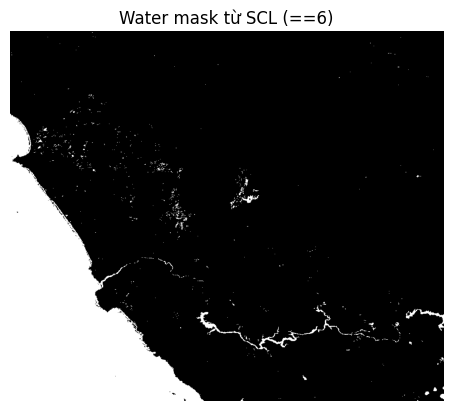

In [11]:
# =========================================================
# Cell 7 — WATER MASK (SCL == 6)
# =========================================================

image_pre_path = "output/cloud_free_sentinel2_pre.tif"
image_post_path = "output/cloud_free_sentinel2_post.tif"

with rasterio.open(image_pre_path) as src_pre:
    scl_pre = src_pre.read(6).astype(np.float32)

with rasterio.open(image_post_path) as src_post:
    scl_post = src_post.read(6).astype(np.float32)

water_mask = np.logical_or(scl_pre == 6, scl_post == 6).astype(np.uint8)

plt.imshow(water_mask, cmap="gray")
plt.title("Water mask từ SCL (==6)")
plt.axis("off")
plt.show()


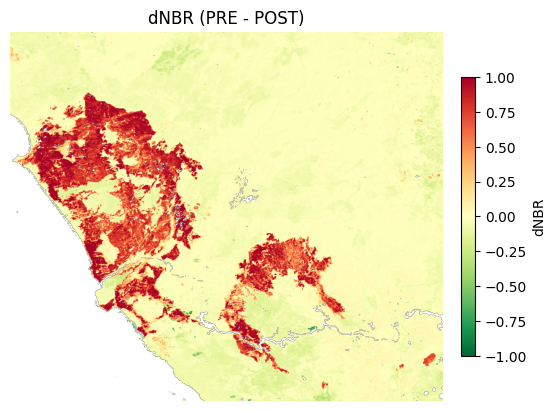

In [12]:
# =========================================================
# Cell 8 — TÍNH NBR & dNBR
# =========================================================

from typing import Tuple

def read_rgb_nir_swir(path: str) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    with rasterio.open(path) as src:
        red = src.read(3).astype(np.float32)    # B4
        green = src.read(2).astype(np.float32)  # B3
        blue = src.read(1).astype(np.float32)   # B2
        nir = src.read(4).astype(np.float32)    # B8
        swir = src.read(5).astype(np.float32)   # B12
    return red, green, blue, nir, swir

# PRE
_, _, _, nir0, swir0 = read_rgb_nir_swir(image_pre_path)
nbr0 = (nir0 - swir0) / (nir0 + swir0 + 1e-10)
nbr0 = np.where(water_mask == 1, np.nan, nbr0)

# POST
_, _, _, nir1, swir1 = read_rgb_nir_swir(image_post_path)
nbr1 = (nir1 - swir1) / (nir1 + swir1 + 1e-10)
nbr1 = np.where(water_mask == 1, np.nan, nbr1)

# dNBR
dnbr = nbr0 - nbr1

plt.figure(figsize=(6, 5))
im = plt.imshow(dnbr, cmap="RdYlGn_r", vmin=-1, vmax=1)
plt.title("dNBR (PRE - POST)")
plt.axis("off")
plt.colorbar(im, fraction=0.03, pad=0.04).set_label("dNBR")
plt.show()


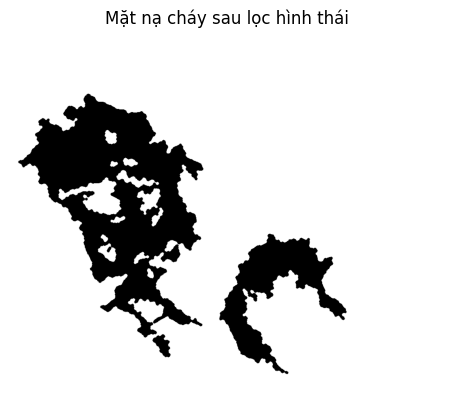

In [13]:
# =========================================================
# Cell 9 — NGƯỠNG dNBR & LỌC HÌNH THÁI
# =========================================================

DNBR_THRESH = 0.10  # tinh chỉnh theo vùng/ảnh

mask_raw = (dnbr > DNBR_THRESH).astype(np.uint8)

kernel = disk(3)
closed = binary_closing(mask_raw, kernel)
eroded = binary_erosion(closed, kernel)
dilated = binary_dilation(eroded, kernel)
no_small = remove_small_objects(dilated, min_size=100)
filled = remove_small_holes(no_small, area_threshold=100)
burnt_mask = remove_small_objects(filled, min_size=500)

plt.imshow(burnt_mask, cmap="gray_r")
plt.title("Mặt nạ cháy sau lọc hình thái")
plt.axis("off")
plt.show()


In [14]:
# =========================================================
# Cell 10 — ƯỚC LƯỢNG DIỆN TÍCH CHÁY
# =========================================================

pixel_area_m2 = 100.0 ** 2   # scale export 100 m
ha_per_m2 = 1e-4

burnt_pixels = int(np.count_nonzero(burnt_mask))
burnt_area_ha = burnt_pixels * pixel_area_m2 * ha_per_m2

print(f"🌏 Diện tích cháy ước lượng: {burnt_area_ha:,.0f} ha (scale 100 m)")


🌏 Diện tích cháy ước lượng: 126,912 ha (scale 100 m)


In [15]:
# =========================================================
# Cell 11 — RESAMPLE RASTER → LƯỚI MÔ PHỎNG (EPSG:3857)
# =========================================================

def resample_raster_to_grid(
    raster_data: np.ndarray,
    output_bbox: Tuple[float, float, float, float],
    resolution: float,
    transform,
    crs: str,
) -> np.ndarray:
    transformer_to_m = Transformer.from_crs(crs, "EPSG:3857", always_xy=True)

    xmin, ymin, xmax, ymax = output_bbox
    min_x, min_y = transformer_to_m.transform(xmin, ymin)
    max_x, max_y = transformer_to_m.transform(xmax, ymax)

    n_x = int((max_x - min_x) / resolution)
    n_y = int((max_y - min_y) / resolution)

    dst_transform = from_origin(min_x, max_y, resolution, resolution)
    dst_shape = (n_y, n_x)

    dst_array = np.empty(dst_shape, dtype=raster_data.dtype)

    reproject(
        source=raster_data,
        destination=dst_array,
        src_transform=transform,
        src_crs=crs,
        dst_transform=dst_transform,
        dst_crs="EPSG:3857",
        resampling=Resampling.bilinear,
    )
    return dst_array


Shape gốc : (827, 969)
Shape lưới: (285, 189)


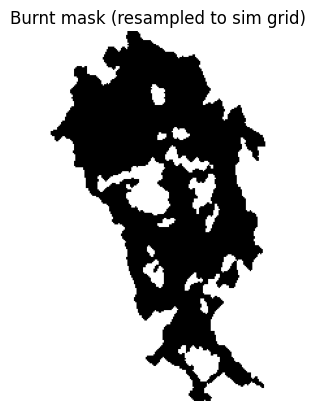

In [16]:
# =========================================================
# Cell 12 — RESAMPLE MASK CHÁY & LƯU .NPY
# =========================================================

ds_pre = rxr.open_rasterio(image_pre_path, masked=True)
src_crs = ds_pre.rio.crs
src_transform = ds_pre.rio.transform()

# Lưới mô phỏng mục tiêu (WGS84 bbox → 3857 grid)
output_resolution = 250  # mét
output_bbox = (144.73, -41.77, 145.155, -41.29)  # [xmin, ymin, xmax, ymax]

burnt_uint8 = burnt_mask.astype(np.uint8)
burnt_resampled = resample_raster_to_grid(
    raster_data=burnt_uint8,
    output_bbox=output_bbox,
    resolution=output_resolution,
    transform=src_transform,
    crs=str(src_crs),
)

print("Shape gốc :", burnt_uint8.shape)
print("Shape lưới:", burnt_resampled.shape)

plt.imshow(burnt_resampled, cmap="gray_r")
plt.title("Burnt mask (resampled to sim grid)")
plt.axis("off")
plt.show()

np.save("output/burnt_area_mask.npy", burnt_resampled)


In [17]:
# =========================================================
# Cell 13 — RASTER → POLYGON (SHAPEFILE)
# =========================================================

ds_pre = rxr.open_rasterio(image_pre_path, masked=True)
r_transform = ds_pre.rio.transform()
r_crs = ds_pre.rio.crs

result_iter = shapes(burnt_mask.astype(np.uint8), mask=burnt_mask == 1, transform=r_transform)
geoms = [shp_shape(geom) for geom, val in result_iter if val == 1]

gdf = gpd.GeoDataFrame(geometry=geoms, crs=r_crs)
gdf["burnt"] = 1
gdf.to_file("output/burnt_area.shp", driver="ESRI Shapefile")
print("💾 Đã lưu polygon cháy → output/burnt_area.*")


💾 Đã lưu polygon cháy → output/burnt_area.*


/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Do

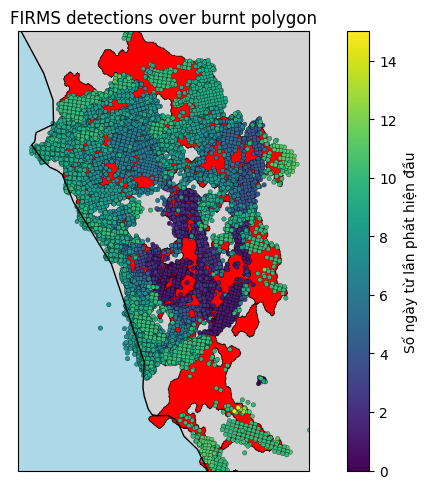

In [24]:
# =========================================================
# Cell 14 — NASA FIRMS (DBF) → VẼ LÊN BẢN ĐỒ
# =========================================================

import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

FP_DIR = "/content/wildfire-mapping-and-simulation-with-cellular-auto/Wildfire-Mapping-and-Simulation-with-Cellular-Automaton/data/FP"

def list_files(folder_path: str, ending: str) -> List[str]:
    files = []
    if not os.path.isdir(folder_path):
        print(f"⚠️ Không thấy thư mục: {folder_path}")
        return files
    for fname in os.listdir(folder_path):
        if fname.lower().endswith(ending.lower()):
            files.append(os.path.join(folder_path, fname))
    return sorted(files)

def read_firms_dbf(file_path: str) -> pd.DataFrame:
    gdf_ = gpd.read_file(file_path)
    cols = ["LONGITUDE", "LATITUDE", "ACQ_DATE", "ACQ_TIME", "INSTRUMENT", "SATELLITE"]
    missing = [c for c in cols if c not in gdf_.columns]
    if missing:
        raise ValueError(f"Thiếu cột trong {file_path}: {missing}")
    df_ = gdf_[cols].rename(
        columns={
            "LONGITUDE": "longitude",
            "LATITUDE": "latitude",
            "ACQ_DATE": "day",
            "ACQ_TIME": "time",
            "INSTRUMENT": "instrument",
            "SATELLITE": "satellite",
        }
    )
    return df_

dbf_paths = list_files(FP_DIR, ".dbf")
if not dbf_paths:
    print("⚠️ Chưa có file .dbf trong data/FP. Tải từ NASA FIRMS rồi chạy lại.")
else:
    df_fp = pd.concat([read_firms_dbf(p) for p in dbf_paths], ignore_index=True)

    df_fp["day"] = pd.to_datetime(df_fp["day"])
    df_fp["time"] = df_fp["time"].astype("int64")
    df_fp["hour"] = df_fp["time"] // 100
    df_fp["minute"] = df_fp["time"] % 100
    df_fp["time_delta"] = (
        pd.to_timedelta(df_fp["hour"], unit="h")
        + pd.to_timedelta(df_fp["minute"], unit="m")
    )
    df_fp["datetime"] = df_fp["day"] + df_fp["time_delta"]
    start_dt = df_fp["datetime"].min()
    df_fp["day_number"] = (df_fp["datetime"] - start_dt).dt.days

    fig = plt.figure(figsize=(8, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([144.73, 145.155, -41.77, -41.29], crs=ccrs.PlateCarree())
    ax.coastlines(resolution="10m")
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.add_feature(cfeature.LAND, facecolor="lightgray")
    ax.add_feature(cfeature.OCEAN, facecolor="lightblue")
    ax.add_feature(cfeature.LAKES, facecolor="lightblue")
    ax.add_feature(cfeature.RIVERS)

    shp_path = "output/burnt_area.shp"
    if os.path.exists(shp_path):
        poly = gpd.read_file(shp_path).to_crs(epsg=4326)
        poly.plot(ax=ax, facecolor="red", edgecolor="black", linewidth=0.5, transform=ccrs.PlateCarree())

    sc = ax.scatter(
        df_fp["longitude"],
        df_fp["latitude"],
        c=df_fp["day_number"],
        s=10,
        edgecolor="k",
        linewidth=0.2,
        cmap="viridis",
        transform=ccrs.PlateCarree(),
    )
    plt.colorbar(sc, ax=ax, label="Số ngày từ lần phát hiện đầu")
    ax.set_title("FIRMS detections over burnt polygon")
    plt.tight_layout()
    plt.show()


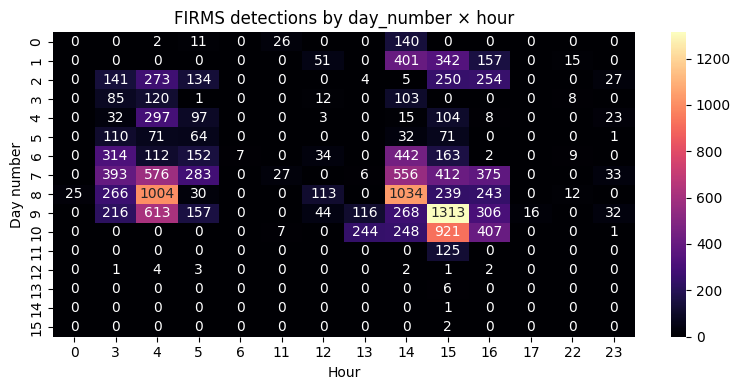

In [25]:
# =========================================================
# Cell 15 — HEATMAP DAY × HOUR CHO FIRMS
# =========================================================

import seaborn as sns

if "df_fp" in globals() and not df_fp.empty:
    df_fp["date"] = df_fp["datetime"].dt.date
    df_fp["hour"] = df_fp["datetime"].dt.hour
    heatmap_data = df_fp.groupby(["day_number", "hour"]).size().unstack(fill_value=0)

    plt.figure(figsize=(8, 4))
    sns.heatmap(heatmap_data, cmap="magma", annot=True, fmt="d")
    plt.title("FIRMS detections by day_number × hour")
    plt.xlabel("Hour")
    plt.ylabel("Day number")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Không có df_fp để vẽ heatmap. Kiểm tra Cell 14.")


In [26]:
# =========================================================
# Cell 16 — CHỌN ĐIỂM MỒI LỬA SỚM & LƯU NPY
# =========================================================

if "df_fp" in globals() and not df_fp.empty:
    df_seed = df_fp[(df_fp["day_number"] == 0) & (df_fp["time"] < 600)]
    if df_seed.empty:
        print("ℹ️ Không thấy điểm rất sớm. Dùng toàn bộ day_number = 0.")
        df_seed = df_fp[df_fp["day_number"] == 0]

    ignitions = df_seed[["longitude", "latitude"]].head(5).to_numpy()
    np.save("output/fire_points_export.npy", ignitions)
    print(f"💾 Đã lưu ignition points ({ignitions.shape[0]} điểm) → output/fire_points_export.npy")
else:
    print("⚠️ Không có df_fp để chọn ignition points.")


💾 Đã lưu ignition points (5 điểm) → output/fire_points_export.npy


In [27]:
# =========================================================
# Cell 17 — ERA5 (TÙY CHỌN): TẢI & RÚT TRÍCH TRUNG BÌNH
# =========================================================

import xarray as xr

era_fname = "era5_tas_feb_1_16_2025.nc"
if not os.path.exists(era_fname):
    try:
        import cdsapi
        dataset = "reanalysis-era5-land"
        request = {
            "variable": ["2m_temperature", "10m_u_component_of_wind", "10m_v_component_of_wind"],
            "year": "2025",
            "month": "02",
            "day": [f"{d:02d}" for d in range(1, 16 + 1)],
            "time": [f"{h:02d}:00" for h in range(24)],
            "data_format": "netcdf",
            "download_format": "unarchived",
            "area": [-41.0, 144.0, -42.0, 146.0],  # [N, W, S, E]
        }
        cdsapi.Client().retrieve(dataset, request).download(era_fname)
        print("✅ Đã tải ERA5.")
    except Exception as err:
        print("⚠️ Không tải được ERA5 (thiếu key hoặc lỗi mạng). Bỏ qua.")
        print(err)

if os.path.exists(era_fname):
    ds_era = xr.open_dataset(era_fname)
    times = ds_era["valid_time"].values

    t2m_avg, u10_avg, v10_avg = [], [], []
    for t in times:
        x = ds_era.sel(valid_time=t)
        t2m = np.nan_to_num(x["t2m"].values, nan=np.nanmean(x["t2m"].values))
        u10 = np.nan_to_num(x["u10"].values, nan=np.nanmean(x["u10"].values))
        v10 = np.nan_to_num(x["v10"].values, nan=np.nanmean(x["v10"].values))
        t2m_avg.append(np.nanmean(t2m))
        u10_avg.append(np.nanmean(u10))
        v10_avg.append(np.nanmean(v10))

    # Cắt ví dụ cho khớp cửa sổ phân tích
    t2m_avg = np.asarray(t2m_avg, dtype=np.float32)[48:-24]
    u10_avg = np.asarray(u10_avg, dtype=np.float32)[48:-24]
    v10_avg = np.asarray(v10_avg, dtype=np.float32)[48:-24]
    times = times[48:-24]

    print("ERA5 shapes:", t2m_avg.shape, u10_avg.shape, v10_avg.shape)
else:
    times = np.array([])
    t2m_avg = np.array([])
    u10_avg = np.array([])
    v10_avg = np.array([])


⚠️ Không tải được ERA5 (thiếu key hoặc lỗi mạng). Bỏ qua.
Missing/incomplete configuration file: /root/.cdsapirc


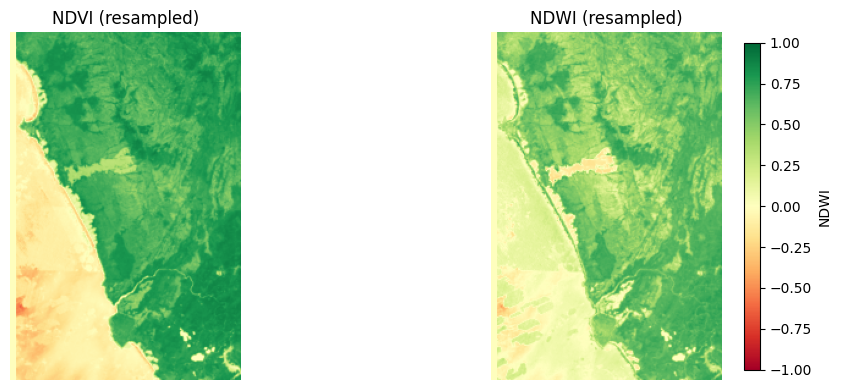

In [28]:
# =========================================================
# Cell 18 — NDVI/NDWI & RESAMPLE VỀ LƯỚI MÔ PHỎNG
# =========================================================

with rasterio.open(image_pre_path) as src:
    red = src.read(3).astype(np.float32)   # B4
    nir = src.read(4).astype(np.float32)   # B8
    swir = src.read(5).astype(np.float32)  # B12
    src_crs_rio = src.crs
    src_transform_rio = src.transform

ndvi = (nir - red) / (nir + red + 1e-10)
ndwi = (nir - swir) / (nir + swir + 1e-10)  # biến thể NDWI dùng SWIR

ndvi_res = resample_raster_to_grid(
    raster_data=ndvi,
    output_bbox=output_bbox,
    resolution=output_resolution,
    transform=src_transform_rio,
    crs=str(src_crs_rio),
)
ndwi_res = resample_raster_to_grid(
    raster_data=ndwi,
    output_bbox=output_bbox,
    resolution=output_resolution,
    transform=src_transform_rio,
    crs=str(src_crs_rio),
)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(ndvi_res, cmap="RdYlGn", vmin=-1, vmax=1)
axs[0].set_title("NDVI (resampled)")
axs[0].axis("off")
im = axs[1].imshow(ndwi_res, cmap="RdYlGn", vmin=-1, vmax=1)
axs[1].set_title("NDWI (resampled)")
axs[1].axis("off")
plt.colorbar(im, ax=axs[1], fraction=0.03, pad=0.04).set_label("NDWI")
plt.tight_layout()
plt.show()


Generating URL ...
Please wait ...
Data downloaded to /content/wildfire-mapping-and-simulation-with-cellular-auto/output/elevation_COPERNICUS.tif
💾 Saved DEM: output/elevation_COPERNICUS.tif


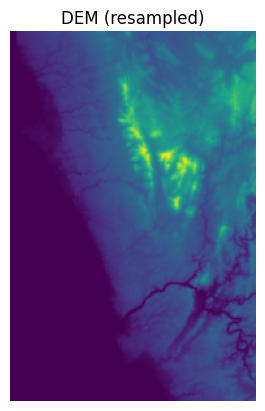

In [29]:
# =========================================================
# Cell 19 — DEM COPERNICUS GLO30 → RESAMPLE
# =========================================================

dem_img = (
    ee.ImageCollection("COPERNICUS/DEM/GLO30")
    .filterBounds(aoi)
    .median()
    .select("DEM")
)

def export_dem_safe(image: ee.Image, out_path: str, region_geom: ee.Geometry) -> None:
    """Export DEM an toàn (tránh tham số gây lỗi)."""
    geemap.ee_export_image(
        image.reproject(crs="EPSG:4326", scale=50).clip(region_geom),
        filename=out_path,
        region=region_geom,
        scale=50,
        file_per_band=False,
    )
    print(f"💾 Saved DEM: {out_path}")

dem_path = "output/elevation_COPERNICUS.tif"
export_dem_safe(dem_img, dem_path, aoi)

with rasterio.open(dem_path) as src_dem:
    dem = src_dem.read(1).astype(np.float32)
    dem_crs = src_dem.crs
    dem_transform = src_dem.transform

dem_res = resample_raster_to_grid(
    raster_data=dem,
    output_bbox=output_bbox,
    resolution=output_resolution,
    transform=dem_transform,
    crs=str(dem_crs),
)

plt.imshow(dem_res)
plt.title("DEM (resampled)")
plt.axis("off")
plt.show()


In [30]:
# =========================================================
# Cell 20 — GÓI DỮ LIỆU CHO CA (pickle)
# =========================================================

import pickle

xmin, ymin, xmax, ymax = output_bbox
to_m = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
min_x, min_y = to_m.transform(xmin, ymin)
max_x, max_y = to_m.transform(xmax, ymax)

resolution_m = float(output_resolution)
x_coords = np.arange(min_x, max_x, resolution_m)
y_coords = np.arange(min_y, max_y, resolution_m)

ignitions_path = "output/fire_points_export.npy"
if os.path.exists(ignitions_path):
    ignition_points = np.load(ignitions_path)
else:
    ignition_points = np.empty((0, 2), dtype=np.float32)
    print("ℹ️ Chưa có ignition points (bạn có thể thêm sau).")

coords_dict = {
    "min_lat": ymin,
    "max_lat": ymax,
    "min_lon": xmin,
    "max_lon": xmax,
    "resolution": resolution_m,
    "x_grid": x_coords,
    "y_grid": y_coords,
}

ca_grid = {
    "CRS": "EPSG:3857",
    "coords": coords_dict,
    "NDVI": ndvi_res,
    "NDWI": ndwi_res,
    "DEM": dem_res,
    "times": times,
    "temperature": t2m_avg,
    "wind_u": u10_avg,
    "wind_v": v10_avg,
    "burnt_area": np.load("output/burnt_area_mask.npy"),
    "ignition_points": ignition_points,
}

with open("output/CA_data.pkl", "wb") as f:
    pickle.dump(ca_grid, f)

print("✅ Đã lưu gói dữ liệu mô phỏng → output/CA_data.pkl")


✅ Đã lưu gói dữ liệu mô phỏng → output/CA_data.pkl


# Git Push

In [ ]:
!pip -q install gdown

!gdown 11HDywYMeYieoukPKI9m9LhPtxraRWIus \
  -O "/content/wildfire-mapping-and-simulation-with-cellular-auto/wildfire-mapping-and-simulation-with-cellular-auto.ipynb"

In [ ]:
# Đẩy lại lên git
!git push -u origin main